In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../../"))

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"
from desc import set_device
set_device("gpu")

In [2]:
import numpy as np
np.set_printoptions(linewidth=np.inf, precision=4, suppress=True, threshold=sys.maxsize)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import functools
import scipy

In [3]:
import desc

from desc.basis import *
from desc.backend import *
from desc.compute import *
from desc.coils import *
from desc.equilibrium import *
from desc.examples import *
from desc.grid import *
from desc.geometry import *

from desc.objectives import *
from desc.objectives.objective_funs import *
from desc.objectives.getters import *
from desc.objectives.normalization import compute_scaling_factors
from desc.objectives.utils import *
from desc.optimize._constraint_wrappers import *

from desc.transform import Transform
from desc.plotting import *
from desc.optimize import *
from desc.perturbations import *
from desc.profiles import *
from desc.compat import *
from desc.utils import *
from desc.magnetic_fields import *

from desc.__main__ import main
from desc.vmec_utils import vmec_boundary_subspace
from desc.input_reader import InputReader
from desc.continuation import solve_continuation_automatic
from desc.compute.data_index import register_compute_fun
from desc.optimize.utils import solve_triangular_regularized

print_backend_info()

DESC version=0.15.0+509.g78c8b1163.
Using JAX backend: jax version=0.6.2, jaxlib version=0.6.2, dtype=float64.
Using device: NVIDIA GeForce RTX 4080 Laptop GPU (id=0), with 10.88 GB available memory.


In [4]:
from desc.particles import *
from diffrax import *

In [5]:
from desc.objectives.objective_funs import _Objective

class DirectParticleTracing(_Objective):
    """Confinement metric for radial transport from direct tracing.

    Traces particles in flux coordinates within the equilibrium, and
    returns a confinement metric based off of the deviation of
    the particle trajectory from its initial flux surface.

    Parameters
    ----------
    eq : Equilibrium
        Equilibrium that will be optimized to satisfy the Objective.
    iota_grid : Grid, optional
        Grid to evaluate rotational transform profile on.
        Defaults to ``LinearGrid(L=eq.L_grid, M=eq.M_grid, N=eq.N_grid)``.
    particles : ParticleInitializer
        should initialize them in flux coordinates, same seed
        will be used each time.
    model : TrajectoryModel
        should be either Vacuum or SlowingDown

    """

    __doc__ = __doc__.rstrip() + collect_docs(
        target_default="``target=0``.", bounds_default="``target=0``."
    )
    _static_attrs = _Objective._static_attrs + [
        "_trace_particles",
        "_max_steps",
        "_has_iota_profile",
        "_saveat",
        "_stepsize_controller",
        "_adjoint",
        "_event",
        "_particle_chunk_size",
    ]

    _coordinates = "rtz"
    _units = "(dimensionless)"
    _print_value_fmt = "Particle Confinement error: "

    def __init__(
        self,
        eq,
        particles,
        model,
        solver=Tsit5(),
        ts=jnp.arange(0, 1e-3, 100),
        iota_grid=None,
        saveat=None,
        stepsize_controller=None,
        adjoint=RecursiveCheckpointAdjoint(),
        max_steps=None,
        min_step_size=1e-8,
        particle_chunk_size=None,
        target=None,
        bounds=None,
        weight=1,
        normalize=False,
        normalize_target=False,
        loss_function=None,
        deriv_mode="auto",
        name="Particle Confinement",
        jac_chunk_size=None,
    ):
        if target is None and bounds is None:
            target = 0
        self._ts = jnp.asarray(ts)
        self._saveat = saveat if saveat is not None else SaveAt(ts=ts)
        self._adjoint = adjoint
        if max_steps is None:
            max_steps = 10
            max_steps = int((ts[-1] - ts[0]) / min_step_size * max_steps)
        self._max_steps = max_steps
        self._min_step_size = min_step_size
        self._stepsize_controller = (
            stepsize_controller
            if stepsize_controller is not None
            else PIDController(rtol=1e-4, atol=1e-4, dtmin=min_step_size)
        )
        self._iota_grid = iota_grid
        assert model.frame == "flux", "can only trace in flux coordinates"
        self._model = model
        self._particles = particles
        self._solver = solver
        self._has_iota_profile = eq.iota is not None
        self._particle_chunk_size = particle_chunk_size
        super().__init__(
            things=eq,
            target=target,
            bounds=bounds,
            weight=weight,
            normalize=normalize,
            normalize_target=normalize_target,
            loss_function=loss_function,
            deriv_mode=deriv_mode,
            name=name,
            jac_chunk_size=jac_chunk_size,
        )

    def build(self, use_jit=True, verbose=1):
        """Build constant arrays.

        Parameters
        ----------
        use_jit : bool, optional
            Whether to just-in-time compile the objective and derivatives.
        verbose : int, optional
            Level of output.

        """
        # avoid circular import
        from desc.particles import _trace_particles

        eq = self.things[0]
        if self._iota_grid is None:
            iota_grid = LinearGrid(
                L=eq.L_grid, M=eq.M_grid, N=eq.N_grid, NFP=eq.NFP, sym=False
            )
        else:
            iota_grid = self._iota_grid

        self._x0, self._model_args = self._particles.init_particles(
            model=self._model, field=eq
        )

        # one metric per particle
        self._dim_f = self._x0.shape[0]

        # tracing uses carteasian coordinates internally, the termainating event
        # must look at rho values by conversion
        def default_event(t, y, args, **kwargs):
            i = jnp.sqrt(y[0] ** 2 + y[1] ** 2)
            return jnp.logical_or(i < 0.0, i > 1.0)

        self._event = Event(default_event)

        self._trace_particles = _trace_particles

        timer = Timer()
        if verbose > 0:
            print("Precomputing transforms")
        timer.start("Precomputing transforms")

        self._iota_profiles = get_profiles(["iota"], obj=eq, grid=iota_grid)
        self._iota_transforms = get_transforms(["iota"], obj=eq, grid=iota_grid)
        self._iota_power_series = PowerSeriesProfile(sym="even")
        self._iota_power_series.change_resolution(L=eq.L)

        timer.stop("Precomputing transforms")
        if verbose > 1:
            timer.disp("Precomputing transforms")

        super().build(use_jit=use_jit, verbose=verbose)

    def compute(self, params, constants=None):
        """Compute particle tracing metric errors.

        Parameters
        ----------
        params : dict
            Dictionary of equilibrium degrees of freedom, eg Equilibrium.params_dict
        constants : dict
            Dictionary of constant data, eg transforms, profiles etc. Defaults to
            self.constants

        Returns
        -------
        f : ndarray
            Average deviation in rho from initial surface, for each particle.
        """
        if not self._has_iota_profile:
            # compute and fit iota profile beforehand, as
            # particle trace only computes things one point at a time
            # and thus cannot do the flux surf averages required for iota
            eq = self.things[0]
            data = compute_fun(
                eq, ["rho", "iota"], params, self._iota_transforms, self._iota_profiles
            )
            iota_values = self._iota_transforms["grid"].compress(data["iota"])
            rho = self._iota_transforms["grid"].compress(data["rho"])
            x = rho**2
            iota_prof = self._iota_power_series
            order = iota_prof.basis.L // 2
            iota_params = jnp.polyfit(
                x, iota_values, order, rcond=None, w=None, full=False
            )[::-1]
            params["i_l"] = iota_params
        else:
            iota_prof = None

        rpz, _ = self._trace_particles(
            field=self.things[0],
            y0=self._x0,
            model=self._model,
            model_args=self._model_args,
            ts=self._ts,
            params=params,
            stepsize_controller=self._stepsize_controller,
            saveat=self._saveat,
            max_steps=self._max_steps,
            min_step_size=self._min_step_size,
            solver=self._solver,
            adjoint=self._adjoint,
            event=self._event,
            options={"iota": iota_prof},
            chunk_size=self._particle_chunk_size,
            throw=False,
            return_aux=False,
        )

        # rpz is shape [N_particles, N_time, 3], take just index rho
        rhos = rpz[:, :, 0]
        rho0s = self._x0[:, 0]

        def fit_line(y):
            ts = self._ts
            # replace nans with zeros, since (0,0) is already the initial
            # point, this will not affect the fit
            y = jnp.where(jnp.isnan(y), 0.0, y)
            ts = jnp.where(jnp.isnan(y), 0.0, ts)
            coeffs = jnp.polyfit(ts, y, 1)
            return coeffs[0]

        slopes = vmap(fit_line)(rhos - rho0s[:, None])
        return slopes

In [6]:
try:
    eq = desc.io.load("precise_qa_scaled_solved.h5")
    eqi_scaled = eq.copy()
except:
    eqi = get("precise_QA")
    eq = rescale(eq=eqi, L=("a", 1.7044), B=("<B>", 5.86), copy=True)
    eq.solve(verbose=1);
    eqi_scaled = eq.copy()
    eq.save("precise_qa_scaled_solved.h5")

In [14]:
N = 300  # particles traced
RHO0 = 0.2 * np.ones(N)

model_flux = VacuumGuidingCenterTrajectory(frame="flux")
particles_flux = ManualParticleInitializerFlux(
    rho0=RHO0,
    theta0=np.random.rand(N) * 2 * np.pi,
    zeta0=np.random.rand(N) * 2 * np.pi,
    xi0=np.random.rand(N),
    E=3.5e6,
)

In [15]:
ts = np.linspace(0, 1e-4, 1000)
dt = 1e-8
obj = ObjectiveFunction(
    DirectParticleTracing(
        eq,
        particles=particles_flux,
        model=model_flux,
        solver=Tsit5(),
        ts=ts,
        min_step_size=dt,
        stepsize_controller=PIDController(rtol=1e-3, atol=1e-4, dtmin=dt),
        deriv_mode="rev",
    )
)
obj.build()
# this will print the average deviation in rho from initial surface
# it is obtained through a linear fit of rho vs time
obj.compute_scaled_error(obj.x(eq))

Building objective: Particle Confinement
Precomputing transforms


Array([  -38.8075,   -46.5067,  -174.9528,   124.8052,    67.0957,  -134.2126,  -246.0868,   -42.1961,  -624.6572,   366.9581,  -198.0558,    48.4635,   707.3048,    56.043 ,   787.2558,  -134.9276,   -38.9847,    24.1441,  -694.5992,   -90.2088,  -874.1964,    95.8148,  2900.1907,   109.3615,  -184.5016,    82.7927, -1639.8669,    39.8198, -2307.8002,   -52.0265,    78.3815,  -862.6058,   211.5104,    34.8123,   729.2171,  -242.9682,    44.8456,  2722.4451,    61.4403,  -137.3621,    38.9856,    49.2289,    93.695 ,  -682.1755,   116.455 ,   -35.402 ,   526.8987,   -90.5281,   -42.4107,   -16.048 ,   330.4027,  -198.9772,    -7.1152,    31.1773,   617.5937,   -12.6421,    32.4714,    25.1423,   759.4003,   301.4838,   145.0525,   125.7136,   160.1701,  -234.8787, -1697.6089,  -111.5091, -1274.8725,    31.4183,  -193.4964,   -26.5989,   183.6205,   154.2395,    99.7188,    36.7903,   110.4163, -1812.2145,   -68.3348,    29.4721,     6.5152,    -2.964 ,   140.2389,  -235.63  ,   413.907

In [ ]:
AR = eq.compute("R0/a")["R0/a"]
obj = ObjectiveFunction(
    [
        DirectParticleTracing(
            eq,
            particles=particles_flux,
            model=model_flux,
            solver=Tsit5(),
            ts=np.linspace(0, 1e-4, 1000),
            min_step_size=1e-8,
            stepsize_controller=PIDController(rtol=1e-3, atol=1e-4, dtmin=1e-8),
            deriv_mode="rev",
        ),
        AspectRatio(eq, target=AR, weight=1e3),
    ]
)
constraints = (ForceBalance(eq), FixPressure(eq), FixPsi(eq), FixCurrent(eq))

k = 1
R_modes = eq.surface.R_basis.modes[np.max(np.abs(eq.surface.R_basis.modes), 1) > k, :]
Z_modes = eq.surface.Z_basis.modes[np.max(np.abs(eq.surface.Z_basis.modes), 1) > k, :]
bdry_constraints = (
    FixBoundaryR(eq=eq, modes=R_modes),
    FixBoundaryZ(eq=eq, modes=Z_modes),
)

eq.optimize(
    objective=obj,
    constraints=constraints + bdry_constraints,
    verbose=3,
    maxiter=25,
    options={"max_nfev": 50, "initial_trust_ratio": 1e-2}
);

Building objective: Particle Confinement
Precomputing transforms
Timer: Precomputing transforms = 74.1 ms
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 28.7 ms
Timer: Objective build = 345 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 744 ms
Timer: Objective build = 1.23 sec
Timer: Objective build = 2.27 ms
Timer: Eq Update LinearConstraintProjection build = 4.82 sec
Timer: Proximal projection build = 26.2 sec
Building objective: fixed pressure
Building objective: fixed Psi
Building objective: fixed current
Building objective: lcfs R
Building objective: lcfs Z
Timer: Objective build = 717 ms
Timer: LinearConstraintProjection build = 2.22 sec
Number of parameters: 9
Number of objectives: 301
Timer: Initializing the optimization = 29.2 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0             

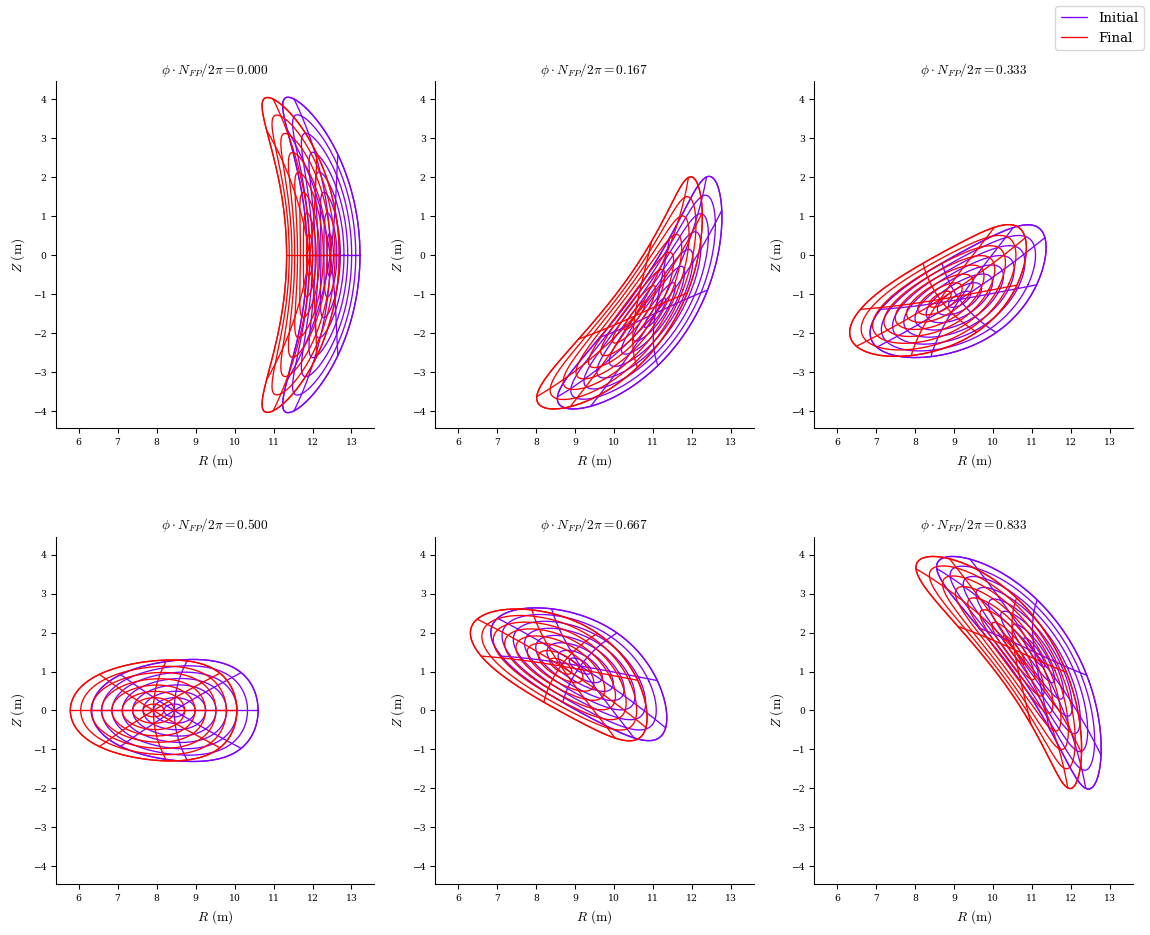

In [48]:
plot_comparison([eqi_scaled, eq], labels=["Initial", "Final"]);

In [ ]:
# eq.save("precise_qa_particle_1e-5_10iter.h5")

In [49]:
ts = np.linspace(0, 1e-5, 1000)
fig = plot_3d(eq, "|B|", alpha=0.3)
fig, data1 = plot_particle_trajectories(
    eq,
    model_flux,
    particles_flux,
    ts,
    fig=fig,
    min_step_size=dt,
    color="blue",
    return_data=True,
)

fig2 = plot_3d(eqi_scaled, "|B|", alpha=0.3)
fig2, data2 = plot_particle_trajectories(
    eqi_scaled,
    model_flux,
    particles_flux,
    ts,
    fig=fig2,
    min_step_size=dt,
    color="red",
    return_data=True,
)

/CODES/DESC/desc/utils.py:572: UserWarning:

Unequal number of field periods for grid 1 and basis 2.

/CODES/DESC/desc/utils.py:572: UserWarning:

Unequal number of field periods for grid 1 and basis 2.

/CODES/DESC/desc/utils.py:572: UserWarning:

Unequal number of field periods for grid 1 and basis 2.

/CODES/DESC/desc/utils.py:572: UserWarning:

Unequal number of field periods for grid 1 and basis 2.



In [50]:
# fig.write_html("optimized_particle_orbits.html")
fig

In [51]:
# fig.write_html("unoptimized_particle_orbits.html")
fig2

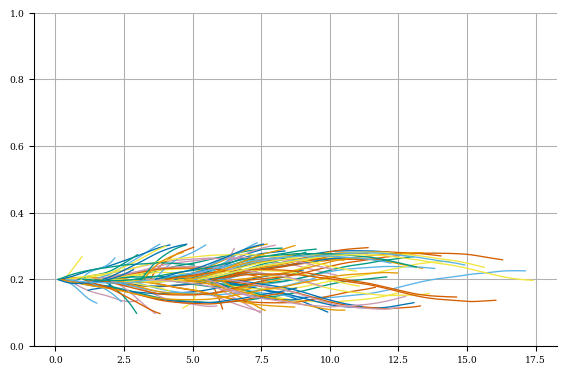

In [52]:
for i, (rhos, phis) in enumerate(zip(data1["rho"], data1["phi"])):
    plt.plot(phis, rhos)
plt.ylim([0,1])
plt.grid()

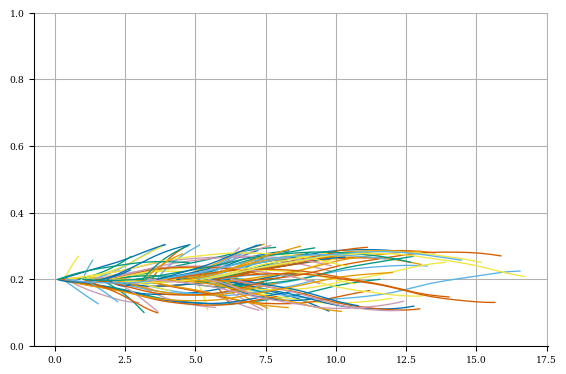

In [53]:
for i, (rhos, phis) in enumerate(zip(data2["rho"], data2["phi"])):
    plt.plot(phis, rhos)
plt.ylim([0, 1])
plt.grid()